In [ ]:
!ls

drive  sample_data


In [ ]:
cd drive/My Drive/

/content/drive/My Drive


In [ ]:
!ls
# !rm -rf dataset_dogs_vs_cats

CatAndDogClassification.ipynb  DogAndCatClassification.py      Pipfile
darknet-gun-only.zip	       final_model.h5		       requirements.txt
data			       ipykernel_launcher.py_plot.png
dataset_dogs_vs_cats	       model


In [ ]:
# !unzip "dogs-vs-cats.zip"
# !unzip "train.zip"
!unzip "test1.zip"

PLOTTING DATA


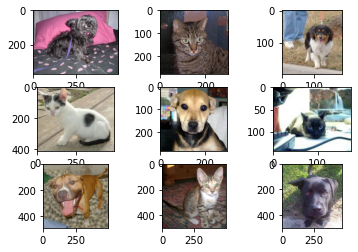

In [ ]:
# plot dog photos from the dogs vs cats dataset
from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset
folder = 'data/train/'
# plot first few images
for i in range(9):
# define subplot
  pyplot.subplot(330 + 1 + i)
  filemame = ""
# define filename
  if i % 2 == 0:
    filename = folder + 'dog.' + str(i) + '.jpg'
  else:
    filename = folder + 'cat.' + str(i) + '.jpg'
# load image pixels
  image = imread(filename)
# plot raw pixel data
  pyplot.imshow(image)
# show the figure
pyplot.show()

PREPROCESS

Split train data into dog and cat label by picture name.
Pick 25% of train set for validation purpose


In [ ]:
# # organize dataset into a useful structure
# from os import makedirs
# from os import listdir
# from shutil import copyfile
# from random import seed
# from random import random
# # create directories
# dataset_home = 'dataset_dogs_vs_cats/'
# subdirs = ['train/', 'test/']
# for subdir in subdirs:
# # create label subdirectories
# 	labeldirs = ['dogs/', 'cats/']
# 	for labldir in labeldirs:
# 		newdir = dataset_home + subdir + labldir
# 		makedirs(newdir, exist_ok=True)
# # seed random number generator
# seed(1)
# # define ratio of pictures to use for validation
# val_ratio = 0.25
# # copy training dataset images into subdirectories
# src_directory = 'data/train/'
# for file in listdir(src_directory):
# 	src = src_directory + '/' + file
# 	dst_dir = 'train/'
# 	if random() < val_ratio: #picking pick
# 		dst_dir = 'test/'
# 	if file.startswith('dog'):
# 		dst = dataset_home + dst_dir + 'dogs/'  + file
# 		copyfile(src, dst)
# 	elif file.startswith('cat'):
# 		dst = dataset_home + dst_dir + 'cats/'  + file
# 		copyfile(src, dst)

Pre-process Into Standard Directories

THE MODEL

-Use VGG models as they achieved top performance in ILSVRC 2014 competition, modular stucture is easy to understand.
Consist of:
-Convolution layer with small 3x3 filters.
-Max pooling mapping layer
-form into block with layer in each box increase 32, 64, 128, 256....
-Paddiing to make sure output geature matches the upcomming input layer.
-ReLU activation layer(avoid vanishing gradient descent) and He weight initialization.

# block 1
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
# block 2
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
# block 3
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
# block 4
model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))

Each layer added 0.2 percent drop out to avoid overfiiting
Dense layer added 0.5 percent drop out

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(224, 224, 3)))
	model.add(MaxPooling2D((2, 2)))
	# model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	# model.add(Dropout(0.2))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	# model.add(Dropout(0.2))
	model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	# model.add(Dropout(0.2))
	# model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	# model.add(MaxPooling2D((2, 2)))
	# model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
	# model.add(Dropout(0.5))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

PLOT LEARNING CURVE

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import sys
def summarize_diagnostics(history):
# plot loss
  pyplot.subplot(211)
  pyplot.title('Cross Entropy Loss')
  pyplot.plot(history.history['loss'], color='blue', label='train')
  pyplot.plot(history.history['val_loss'], color='orange', label='test')
# plot accuracy
  pyplot.subplot(212)
  pyplot.title('Classification Accuracy')
  pyplot.plot(history.history['accuracy'], color='blue', label='train')
  pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
# save plot to file
  filename = sys.argv[0].split('/')[-1]
  pyplot.savefig(filename + '_plot.png')
  pyplot.close()

RUN MODEL


In [ ]:
# run the test harness for evaluating a model
def run_test_harness():
# define model
  model = define_model()
# create data generator and augment data to get better feature for learning model
  train_datagen = ImageDataGenerator(rescale=1.0/255.0, width_shift_range=0.1, 
  height_shift_range=0.1, horizontal_flip=True)
  test_datagen = ImageDataGenerator(rescale=1.0/255.0) 
# prepare iterators
  train_it = train_datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
  class_mode='binary', batch_size=64, target_size=(224, 224))
  test_it = test_datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
  class_mode='binary', batch_size=64, target_size=(224, 224))
# fit model
  history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
    validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)
  #saving model
  model.save('final_model.h5')
# evaluate model
  _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
  print('> %.3f' % (acc * 100.0))
# learning curves
  summarize_diagnostics(history)

In [ ]:
run_test_harness() #execute

FileNotFoundError: ignored

Save Final Model

MAKE PREDICTION


In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
 
# load and prepare the image
def load_image(filename):
	# load the image
	img = load_img(filename, target_size=(224, 224))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 3 channels
	img = img.reshape(1, 224, 224, 3)
	# center pixel data
	img = img.astype('float32')
	img = img - [123.68, 116.779, 103.939]
	return img
 
# load an image and predict the class
def run_example():
	# load the image
	img = load_image('data/test1/.jpg')
	# load model
	model = load_model('final_model.h5')
	# predict the class
	result = model.predict(img)
	print(result[0])
 
# entry point, run the example
run_example()

In [ ]:
!pip install pillow

USE TRANSFER LEARNING

In [ ]:
import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
 
# define cnn model
def define_model():
	# load model
	model = VGG16(include_top=False, input_shape=(224, 224, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(1, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model
 
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.close()
 
# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(featurewise_center=True)
	# specify imagenet mean values for centering
	datagen.mean = [123.68, 116.779, 103.939]
	# prepare iterator
	train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
		class_mode='binary', batch_size=64, target_size=(224, 224))
	test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
		class_mode='binary', batch_size=64, target_size=(224, 224))
	# fit model
	history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=10, verbose=1)
	# evaluate model
	_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)
 
# entry point, run the test harness
run_test_harness()

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/10
293/293 [==============================] - 14614s 50s/step - loss: 0.2252 - accuracy: 0.9664 - val_loss: 0.0645 - val_accuracy: 0.9737
Epoch 2/10
293/293 [==============================] - 139s 474ms/step - loss: 0.0230 - accuracy: 0.9922 - val_loss: 0.0663 - val_accuracy: 0.9767
Epoch 3/10
293/293 [==============================] - 139s 474ms/step - loss: 0.0052 - accuracy: 0.9992 - val_loss: 0.0752 - val_accuracy: 0.9767
Epoch 4/10
293/293 [==============================] - 138s 472ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0852 - val_accuracy: 0.9776
Epoch 5/10
293/293 [==============================] - 139s 473ms/step - loss: 5.2043e-04 - accuracy: 1.0000 - val_loss: 0.0909 - val_accuracy: 0.9768
Epoch 6/10
293/293 [==============================] - 139s 475ms/step - loss: 3.4631e-04 - accuracy: 1.0000 - val_loss: 0.0945 - val_accuracy: 0.9768
Epoch 7/10
293/293 [===========